In [17]:
import pandas as pd
import io
import requests
import numpy as np
import collections
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [30]:
dt = pd.read_csv('C:/Users/Owner/Documents/Sac State/CSC215_P2_Stock_Price.csv')
dt['Close_y'] = dt['Close']
split = int(0.7 * len(dt))
df_train = dt[:split]
df_test = dt[split:len(dt)]

print("Training set has {} records.".format(len(df_train)))
print("Test set has {} records.".format(len(df_test)))


Training set has 3074 records.
Test set has 1318 records.


Since we want to ensure time-based relationships between observations, we split the data in a sequential way. The first 70% of observations are in the training set, with the remaining in our test.
Additoinally, we create a new column 'Close_y' to preserve the actual observed closing values. This will be used as our dependent variable. This column is needed as the 'Close' column will be used as an input variable and will be normalized.

In [33]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
        
    if sd is None:
        sd = df[name].std()
        
    df[name] = (df[name] - mean) / sd

normal_list = ['Open', 'High', 'Low', 'Volume', 'Close'];

for element in normal_list:
    encode_numeric_zscore(df_train, element)
    encode_numeric_zscore(df_test, element)    



params_train = df_train[['Open', 'High', 'Low', 'Volume', 'Close']].values.tolist()
params_test = df_test[['Open', 'High', 'Low', 'Volume', 'Close',]].values.tolist()

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Next we normalize the values, and drop the 'date' column from the dataframe. The way we did this caused a warning, however this does not impact our final program.

In [40]:
def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [x for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE,params_train)
obs_train = df_train['Close_y'][SEQUENCE_SIZE:len(close_train)].values.tolist()
obs_train.pop()
obs_train = np.asarray(obs_train)

x_test,y_test = to_sequences(SEQUENCE_SIZE,params_test)
obs_test = df_test['Close_y'][SEQUENCE_SIZE:len(close_train)].values.tolist()
obs_test.pop()
obs_test = np.asarray(obs_test)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(obs_train.shape))
print("Shape of y_test: {}".format(obs_test.shape))

Shape of x_train: (3066, 7, 5)
Shape of x_test: (1310, 7, 5)
Shape of y_train: (3066,)
Shape of y_test: (1310,)


Here we transform our data in sequence data. Now, each record is a sequence of 7 days of data, each with 5 relevant pieces of information on that day's market behavior. Additionally, there is one dependent variable for each of these 7x5 structures which holds the close price of the stock on the seventh day.

In [42]:
myDict = dict()
##activationType = ['relu', 'sigmoid', 'tanh']
optimizerType = ['adam', 'sgd']
iteration = 0

for opt in optimizerType:
    checkpointer = ModelCheckpoint(filepath="C:/Users/Owner/Documents/Sac State/csc215/proj2/best_weights.hdf5", verbose=0, save_best_only=True) # save best model        
    for i in range(2):
        print(i)        
        # Build network
        model = Sequential()
        model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 5)))
        model.add(Dense(32))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=opt)        
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')        
        model.fit(x_train,obs_train,validation_data=(x_test,obs_test), callbacks=[monitor],verbose=2, epochs=100)  


    print('Training finished...Loading the best model')  
    print()
    model.load_weights("C:/Users/Owner/Documents/Sac State/csc215/proj2/best_weights.hdf5") # load weights from best model
    myDict.update({iteration : (opt, model)})
    iteration += 1

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 13s - loss: 128.5266 - val_loss: 2695.8432
Epoch 2/100
3066/3066 - 11s - loss: 4.6985 - val_loss: 2971.3614
Epoch 3/100
3066/3066 - 13s - loss: 2.6382 - val_loss: 2935.3714
Epoch 4/100
3066/3066 - 8s - loss: 2.1825 - val_loss: 2991.2251
Epoch 5/100
3066/3066 - 10s - loss: 1.6790 - val_loss: 2997.3688
Epoch 6/100
3066/3066 - 12s - loss: 1.6147 - val_loss: 2964.6425
Epoch 00006: early stopping
1
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 16s - loss: 111.8785 - val_loss: 2851.5510
Epoch 2/100
3066/3066 - 12s - loss: 4.4044 - val_loss: 2897.6070
Epoch 3/100
3066/3066 - 14s - loss: 2.7755 - val_loss: 2953.3420
Epoch 4/100
3066/3066 - 16s - loss: 2.1863 - val_loss: 2941.9411
Epoch 5/100
3066/3066 - 15s - loss: 2.0506 - val_loss: 2908.2526
Epoch 6/100
3066/3066 - 15s - loss: 1.8262 - val_loss: 3011.5215
Epoch 00006: early stopping
Training finished...Loading the best model

0
Train on 3066 s

Here we use checkpointing and earlystopping to iteration through model construction. Checkpointing allows us to save our best model whereas earlystopping will stop training after the model reaches a certain point on the descent algorithm. 

Analyzing model with optimizer adam


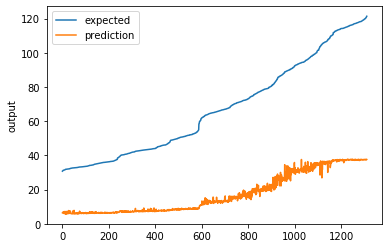

Score (RMSE): 52.66345906562259
Analyzing model with optimizer sgd


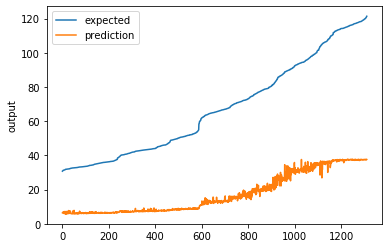

Score (RMSE): 52.66345906562259


In [43]:
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred.flatten(), 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


for ele in myDict.values():
    print('Analyzing model with optimizer {}'.format(ele[0]))
    model = ele[1]
    pred = model.predict(x_test)
    obs_test = np.asarray(obs_test)
    score = np.sqrt(metrics.mean_squared_error(pred,obs_test))
    chart_regression(pred,obs_test)
    print("Score (RMSE): {}".format(score))

Here we see that both models have a very similar RMSE (implying the optimizer makes little to no difference). Additionally, we see the reression lift chart. We find it a bit odd that there seems to be a relatively consistent linear gap between the expected and the prediction. In other words, it seems odd that our predictions seem to attempt to match the slope of the expected but the y intercept is off by about 20. We assume that this it because we split the data in a linear way

Analyzing model with optimizer adam


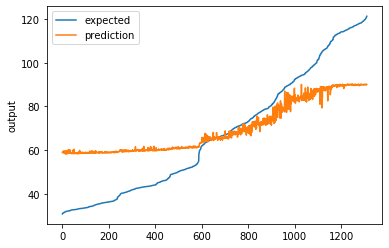

Score (RMSE): 16.769622764052865
Analyzing model with optimizer sgd


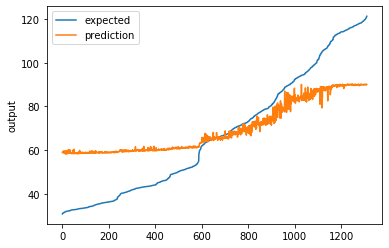

Score (RMSE): 16.769622764052865


In [62]:
for ele in myDict.values():
    print('Analyzing model with optimizer {}'.format(ele[0]))
    model = ele[1]
    pred = model.predict(x_test)
    pred = pred + np.mean(obs_test) - np.mean(obs_train)
    obs_test = np.asarray(obs_test)
    score = np.sqrt(metrics.mean_squared_error(pred,obs_test))
    chart_regression(pred,obs_test)
    print("Score (RMSE): {}".format(score))

In [49]:
###Fully Connected NN
test_NN = []
for ele in x_test:
    flat_list = []
    for sublist in ele:
        for item in sublist:
            flat_list.append(item)
    test_NN.append(flat_list)

train_NN = []
for ele in x_train:
    flat_list = []
    for sublist in ele:
        for item in sublist:
            flat_list.append(item)
    train_NN.append(flat_list)


train_NN = pd.DataFrame(train_NN)
train_NN['out'] = obs_train
test_NN = pd.DataFrame(test_NN)
test_NN['out'] = obs_test


def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


train_NN,y_train2 = to_xy(train_NN, 'out')
test_NN, y_test2 = to_xy(test_NN, 'out')

Moving on to the fully connected neural network. We need to do some data wrangling. First off, we need to change the data from 7 day sequence of 5 fields into a 35 field record. Then, we need to do some structure formatting to interface with tensorflow. After doing preprocessing, we are ready for model building.

In [54]:

myDict2 = dict()
activationType = ['relu', 'sigmoid', 'tanh']
optimizerType = ['adam', 'sgd']
iteration = 0

for act in activationType:
    for opt in optimizerType:
        checkpointer2 = ModelCheckpoint(filepath="C:/Users/Owner/Documents/Sac State/csc215/proj2/best_weights2.hdf5", verbose=0, save_best_only=True) # save best model
        
        for i in range(5):
            print(i)
            model_NN = Sequential()
            model_NN.add(Dense(20, input_dim=train_NN.shape[1], activation=act))
            model_NN.add(Dense(1))
            model_NN.compile(loss='mean_squared_error', optimizer=opt)        
            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')        
            model_NN.fit(train_NN,y_train2,validation_data=(test_NN,y_test2),callbacks=[monitor, checkpointer2],verbose=2,epochs=100)

        print('Training finished...Loading the best model')  
        print()
        model_NN.load_weights("C:/Users/Owner/Documents/Sac State/csc215/proj2/best_weights2.hdf5") # load weights from best model
        myDict2.update({iteration : (act, opt, model_NN)})
        iteration += 1


0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 9s - loss: 225.0617 - val_loss: 4098.3742
Epoch 2/100
3066/3066 - 0s - loss: 50.3751 - val_loss: 3465.3989
Epoch 3/100
3066/3066 - 0s - loss: 36.5715 - val_loss: 3446.7002
Epoch 4/100
3066/3066 - 0s - loss: 27.1199 - val_loss: 3287.7403
Epoch 5/100
3066/3066 - 0s - loss: 17.3244 - val_loss: 3146.7674
Epoch 6/100
3066/3066 - 0s - loss: 9.5220 - val_loss: 3044.7571
Epoch 7/100
3066/3066 - 0s - loss: 5.1733 - val_loss: 3068.6851
Epoch 8/100
3066/3066 - 0s - loss: 3.1285 - val_loss: 3044.5372
Epoch 9/100
3066/3066 - 0s - loss: 1.9138 - val_loss: 3045.6351
Epoch 10/100
3066/3066 - 0s - loss: 1.3215 - val_loss: 3013.1872
Epoch 11/100
3066/3066 - 0s - loss: 0.9480 - val_loss: 3041.1898
Epoch 12/100
3066/3066 - 0s - loss: 0.7358 - val_loss: 3039.6817
Epoch 13/100
3066/3066 - 0s - loss: 0.5646 - val_loss: 3042.1694
Epoch 14/100
3066/3066 - 0s - loss: 0.4852 - val_loss: 3038.0018
Epoch 15/100
3066/3066 - 0s - loss: 0.4206 

Epoch 20/100
3066/3066 - 0s - loss: 0.4722 - val_loss: 3048.6377
Epoch 21/100
3066/3066 - 0s - loss: 0.4313 - val_loss: 3038.4432
Epoch 22/100
3066/3066 - 0s - loss: 0.3795 - val_loss: 3046.8479
Epoch 23/100
3066/3066 - 0s - loss: 0.3775 - val_loss: 3041.8680
Epoch 24/100
3066/3066 - 0s - loss: 0.3533 - val_loss: 3031.3145
Epoch 25/100
3066/3066 - 0s - loss: 0.3339 - val_loss: 3047.3357
Epoch 26/100
3066/3066 - 0s - loss: 0.3198 - val_loss: 3038.2617
Epoch 27/100
3066/3066 - 0s - loss: 0.3041 - val_loss: 3029.6799
Epoch 28/100
3066/3066 - 0s - loss: 0.3213 - val_loss: 3038.2222
Epoch 29/100
3066/3066 - 0s - loss: 0.3034 - val_loss: 3014.3745
Epoch 30/100
3066/3066 - 0s - loss: 0.2883 - val_loss: 3031.4426
Epoch 31/100
3066/3066 - 0s - loss: 0.2914 - val_loss: 3035.0236
Epoch 32/100
3066/3066 - 0s - loss: 0.2621 - val_loss: 3026.1538
Epoch 33/100
3066/3066 - 0s - loss: 0.2707 - val_loss: 3056.1224
Epoch 34/100
3066/3066 - 0s - loss: 0.2683 - val_loss: 3036.0595
Epoch 00034: early stoppi

Epoch 11/100
3066/3066 - 5s - loss: 1.4109 - val_loss: 3038.1029
Epoch 12/100
3066/3066 - 0s - loss: 1.0887 - val_loss: 3079.1084
Epoch 13/100
3066/3066 - 0s - loss: 0.8755 - val_loss: 3037.5574
Epoch 14/100
3066/3066 - 0s - loss: 0.7572 - val_loss: 3054.3245
Epoch 15/100
3066/3066 - 0s - loss: 0.5952 - val_loss: 3053.0521
Epoch 16/100
3066/3066 - 0s - loss: 0.5276 - val_loss: 3053.2681
Epoch 17/100
3066/3066 - 0s - loss: 0.4732 - val_loss: 3050.8254
Epoch 18/100
3066/3066 - 0s - loss: 0.4234 - val_loss: 3042.7495
Epoch 00018: early stopping
2
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 5s - loss: 270.0914 - val_loss: 4552.8590
Epoch 2/100
3066/3066 - 0s - loss: 90.1468 - val_loss: 3587.7712
Epoch 3/100
3066/3066 - 0s - loss: 44.2746 - val_loss: 3437.6546
Epoch 4/100
3066/3066 - 0s - loss: 39.5327 - val_loss: 3454.7729
Epoch 5/100
3066/3066 - 0s - loss: 33.4005 - val_loss: 3423.3820
Epoch 6/100
3066/3066 - 0s - loss: 25.5042 - val_loss: 3321.4079
Epoch 7/100

Epoch 6/100
3066/3066 - 0s - loss: 33.5528 - val_loss: 3384.5978
Epoch 7/100
3066/3066 - 0s - loss: 27.4604 - val_loss: 3339.7822
Epoch 8/100
3066/3066 - 0s - loss: 19.8091 - val_loss: 3231.5590
Epoch 9/100
3066/3066 - 0s - loss: 12.3336 - val_loss: 3180.6911
Epoch 10/100
3066/3066 - 0s - loss: 7.1062 - val_loss: 3117.4866
Epoch 11/100
3066/3066 - 0s - loss: 4.2380 - val_loss: 3145.7292
Epoch 12/100
3066/3066 - 0s - loss: 2.7141 - val_loss: 3109.5766
Epoch 13/100
3066/3066 - 0s - loss: 1.8679 - val_loss: 3102.8719
Epoch 14/100
3066/3066 - 0s - loss: 1.3994 - val_loss: 3050.7517
Epoch 15/100
3066/3066 - 0s - loss: 1.0677 - val_loss: 3049.3046
Epoch 16/100
3066/3066 - 0s - loss: 0.8028 - val_loss: 3066.7367
Epoch 17/100
3066/3066 - 0s - loss: 0.6731 - val_loss: 3027.6680
Epoch 18/100
3066/3066 - 0s - loss: 0.5739 - val_loss: 3046.7291
Epoch 19/100
3066/3066 - 0s - loss: 0.4774 - val_loss: 3047.5460
Epoch 20/100
3066/3066 - 0s - loss: 0.4237 - val_loss: 3036.9595
Epoch 21/100
3066/3066 - 

Epoch 7/100
3066/3066 - 0s - loss: 12.1197 - val_loss: 3118.1738
Epoch 8/100
3066/3066 - 0s - loss: 6.0417 - val_loss: 3092.2483
Epoch 9/100
3066/3066 - 0s - loss: 3.2516 - val_loss: 3067.6291
Epoch 10/100
3066/3066 - 0s - loss: 2.0848 - val_loss: 3049.2634
Epoch 11/100
3066/3066 - 0s - loss: 1.4600 - val_loss: 3031.2705
Epoch 12/100
3066/3066 - 0s - loss: 1.0508 - val_loss: 3039.2638
Epoch 13/100
3066/3066 - 0s - loss: 0.7495 - val_loss: 3031.0795
Epoch 14/100
3066/3066 - 0s - loss: 0.5941 - val_loss: 3041.6881
Epoch 15/100
3066/3066 - 0s - loss: 0.4983 - val_loss: 3039.3720
Epoch 16/100
3066/3066 - 0s - loss: 0.4449 - val_loss: 3038.1185
Epoch 17/100
3066/3066 - 0s - loss: 0.3752 - val_loss: 3041.5665
Epoch 18/100
3066/3066 - 0s - loss: 0.3440 - val_loss: 3046.9751
Epoch 00018: early stopping
2
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 5s - loss: 166.6037 - val_loss: 3722.9182
Epoch 2/100
3066/3066 - 0s - loss: 44.4116 - val_loss: 3454.6029
Epoch 3/100
3

Epoch 7/100
3066/3066 - 0s - loss: 14.0549 - val_loss: 3139.4799
Epoch 8/100
3066/3066 - 0s - loss: 7.9627 - val_loss: 3036.2161
Epoch 9/100
3066/3066 - 0s - loss: 4.2776 - val_loss: 3019.9949
Epoch 10/100
3066/3066 - 0s - loss: 2.3263 - val_loss: 3005.2984
Epoch 11/100
3066/3066 - 5s - loss: 1.3836 - val_loss: 2980.7705
Epoch 12/100
3066/3066 - 0s - loss: 0.9628 - val_loss: 2995.9446
Epoch 13/100
3066/3066 - 0s - loss: 0.7440 - val_loss: 3001.3901
Epoch 14/100
3066/3066 - 0s - loss: 0.5935 - val_loss: 3013.3007
Epoch 15/100
3066/3066 - 0s - loss: 0.4660 - val_loss: 3015.8163
Epoch 16/100
3066/3066 - 0s - loss: 0.4147 - val_loss: 3020.2006
Epoch 00016: early stopping
3
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 6s - loss: 169.9560 - val_loss: 3867.8605
Epoch 2/100
3066/3066 - 0s - loss: 46.2544 - val_loss: 3476.8337
Epoch 3/100
3066/3066 - 0s - loss: 40.8947 - val_loss: 3442.4218
Epoch 4/100
3066/3066 - 0s - loss: 35.7665 - val_loss: 3413.5676
Epoch 5/100
3

Similar to our LTSM, we use early stopping and model checkpointing to iterate (and avoid local optima) and save the weights to reference our best model. However, we are iterating through activation layer types as well as optimerizers. An observation about training these models is that they are much faster than the LTSM (in terms of training time per epoch). However, many more epochs are needed to reache the lost cutoff point.

Analyzing model with activation relu and optimizer adam


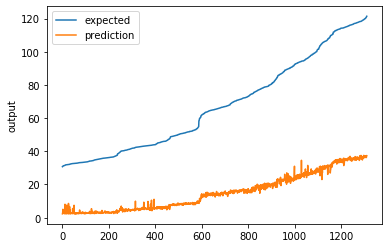

Score (RMSE): 54.89250518423713
Analyzing model with activation relu and optimizer sgd


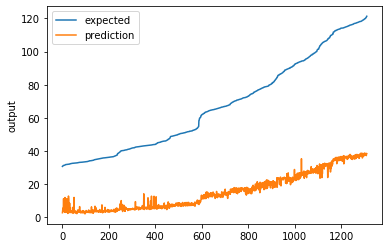

Score (RMSE): 54.561819032219056
Analyzing model with activation sigmoid and optimizer adam


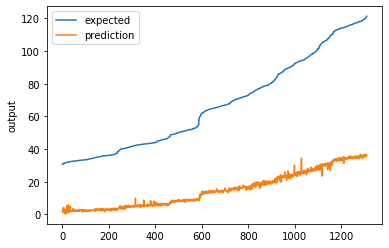

Score (RMSE): 54.92844953287843
Analyzing model with activation sigmoid and optimizer sgd


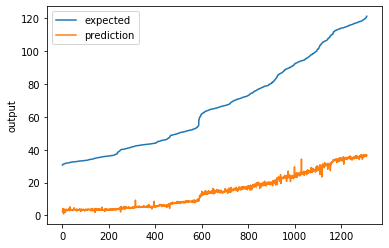

Score (RMSE): 54.833931422388595
Analyzing model with activation tanh and optimizer adam


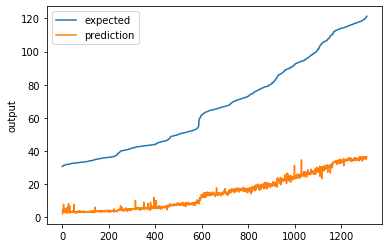

Score (RMSE): 54.94012249429449
Analyzing model with activation tanh and optimizer sgd


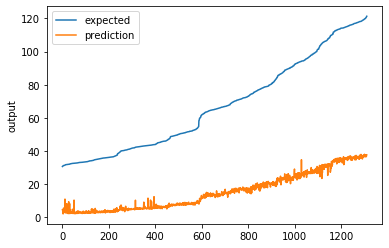

Score (RMSE): 54.5964334264013


In [57]:
for ele in myDict2.values():
    print('Analyzing model with activation {} and optimizer {}'.format(ele[0], ele[1]))
    model_NN = ele[2]
    pred_NN = model_NN.predict(test_NN)
       
    score_NN = np.sqrt(metrics.mean_squared_error(pred_NN,obs_test))
    chart_regression(pred_NN,obs_test)
    print("Score (RMSE): {}".format(score_NN))
    

# Need to rerun model building